# ELMO - задание

В этой части домашки мы немного попробуем поиграться с эмбедингами, обученными на твиттере. Будте аккуратны! Мы в какой-то степени будем сейчас насиловать оперативную память компьютера. Иногда ядро может умирать. Если оно постоянно умирает, это весомый повод не делать это задание.  

# 1. Твиттер

[План будет прост](https://www.youtube.com/watch?v=gmaDsK2Ehzc) потому и красив. Если план сложен, всё может пойти наперекосяк.

* Заберём у IPavlov [ELMO-эмбединги для твиттера](http://docs.deeppavlov.ai/en/master/intro/pretrained_vectors.html) с помощью tensorflow hub
* Немного посмотрим на их свойства

Подгружаем нашу выборку. 

In [2]:
import pandas as pd  # для таблиц
import numpy as np   # для матриц

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Подгружаем данные из твиттера
df_neg = pd.read_csv('negative.csv', sep=';',header=-1)
df_pos = pd.read_csv('positive.csv', sep=';',header=-1)

df = df_pos[[3,4]].append(df_neg[[3,4]])
df.columns = ['text', 'target']
df.reset_index(drop=True, inplace=True)
df.target = df.target.replace({-1:0})

# Выбрасываем из обучения все посты короче 3-х слов.
df = df[df.text.apply(lambda text: len(text.split())) > 2] 

print(df.shape)
df.head()

(226703, 2)


,text,target
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [3]:
df.text.iloc[10]  # пример позитива

'Люблю маму и папу!!!!а в остальное я так...-влюбляюсь, привязываюсь)))\xa0'

In [4]:
df.text.iloc[-10] # пример негатива

'@ivanenko14 и у меня также, только будильник еще и не выключался.. папу разбудила ('

Заниматься чисткой текстов не будем. Судя по всему, эмбединги обучались на грязном корпусе текстов. Это довольно сильно упрощает нашу задачу.

In [5]:
X = df.text.get_values()
y = df.target.get_values()

X[0]

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

Библиотеки.

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

W0408 19:22:49.577055 140736877204416 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


1.13.1


Забираем с помощью хаба у IPavlov модель.

Обратите внимание, что нужна версия tensorflow выше 9. Нормально повышает версию tf до актуальной для python3 в случае проблем следущая команда, вбитая в терминал: 

```python3 -m pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.12.0-py3-none-any.whl```


In [7]:
elmo = hub.Module("http://files.deeppavlov.ai/deeppavlov_data/elmo_ru-twitter_2013-01_2018-04_600k_steps.tar.gz")

Instructions for updating:
Colocations handled automatically by placer.


W0408 19:27:24.869438 140736877204416 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Если у вас выскакивает ошибка 

```
RuntimeError: Missing implementation that supports: 
loader(*('C:\\Users\\Alber\\AppData\\Local\\Temp\\tfhub_modules\\a7fe827a4e68369aab0fa6a65479cd37c499e0f4',), **{})
```

прочтите [трэд](https://github.com/tensorflow/hub/issues/212) с её решением.

Проверяем работоспособность эмбедингов:

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

embeddings = elmo([X[0]], signature="default", as_dict=True)["elmo"]
emb = sess.run(embeddings)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 19:31:31.465476 140736877204416 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [9]:
print(X[0])
emb.shape

@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)


(1, 17, 1024)

Всё работает. На выходе у нас получился тензор, в котором 12 слов и для каждого есть вектор из эмбедингов размера 1024.  Есть даже эмбединг для `:D`.

In [10]:
X[0]

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

In [11]:
X[0].split(' ')[12]

':D'

In [12]:
emb[0][12][:10]

array([ 0.12452237,  0.1960457 ,  0.3939316 ,  0.30602187,  0.20003393,
        0.18350704, -0.4531245 ,  0.5350059 ,  0.13885579,  0.5602584 ],
      dtype=float32)

__Упражнение:__  Попробуйте найти несколько радостных и несколько грустных смайликов. Посмотрите какое расстояние между ними. Попробуйте применить к ним "найди лишнее". 

In [13]:
# Задаём список смайлов и перегоняем его в эмбединги

smiles = [':)', ':(', ')))', '))', ':))', '((', ':D', ':3', ';)', 
          ';(', '=)', ')0)))0))', ':|', '<3', '=(', ':P', ':p']

embeddings = elmo(smiles, signature = "default", as_dict = True)["elmo"]
emb = sess.run(embeddings)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 19:31:56.620261 140736877204416 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [44]:
# Построим матрицу попарных расстояний, будем использовать косинус
from scipy.spatial.distance import cosine

def count_cosine_similarity(X, Y):
    up = np.sum(X[:,np.newaxis]*Y,axis=2)
    down = np.sqrt(np.sum(np.power(X,2),axis=1))[:, np.newaxis]*np.sqrt(np.sum(np.power(Y,2),axis=1)) 
    return up/down

R = count_cosine_similarity(emb.reshape(17,1024), emb.reshape(17,1024))
R.shape

(17, 17)

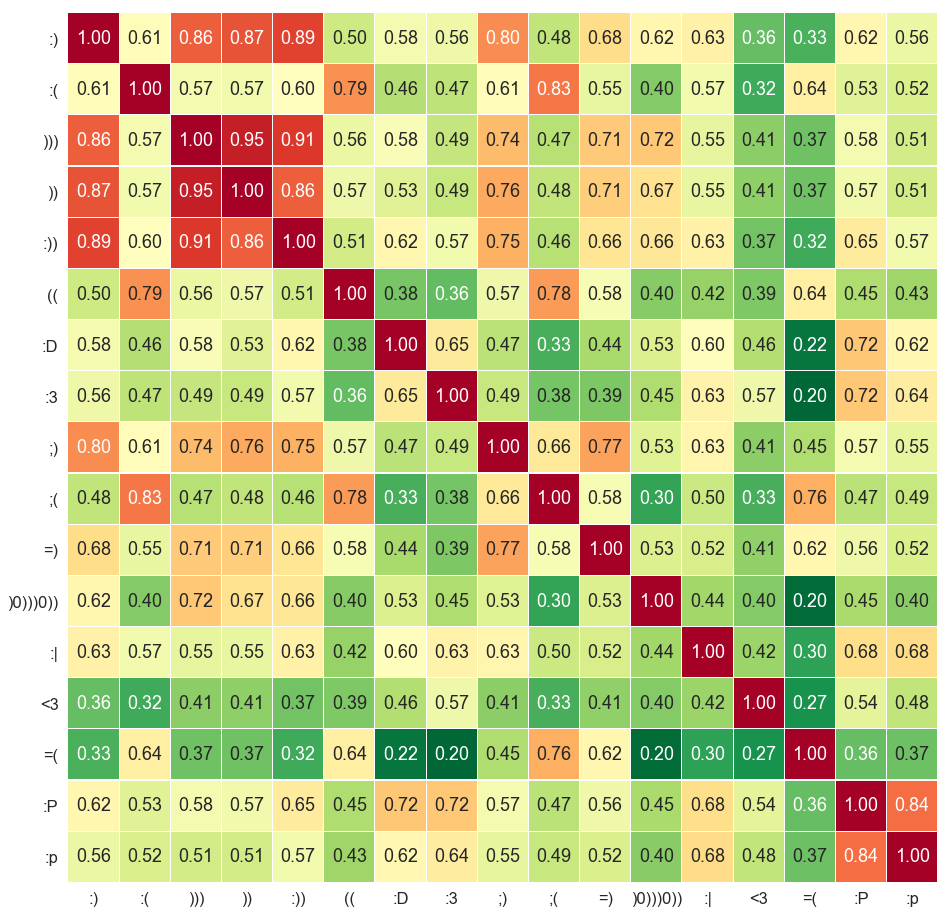

In [40]:
import matplotlib.pyplot as plt  # Пакет для строительства графиков
import seaborn as sns            # Еще один пакет для графиков
plt.style.use('ggplot')          # задаём красивый стиль для графиков matplotlib-а
%matplotlib inline

sns.set(font_scale=1.5)
plt.subplots(figsize=(16, 16))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=smiles, xticklabels=smiles,cbar=False);

In [58]:
# Перегоним все смайлы в векторы и соберём на их основе w2v 
# Внутри вместо w2v векторов для них будут лежать elmo-вектора 

with open('w2v_smiles.txt', "w") as f:
    f.write("{} {}\n".format(len(smiles), 1024))
    for word,vec in zip(smiles, emb.reshape(17,1024)):
        f.write(word + " " + ' '.join([str(item) for item in vec]) + '\n')
        

import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('w2v_smiles.txt')

# Можем смотреть на похожести и делать кучу других штук такихже как с w2v
w2v_model.similar_by_word(':)')

[(':))', 0.894263505935669),
 ('))', 0.8733417987823486),
 (')))', 0.8574975728988647),
 (';)', 0.8005287051200867),
 ('=)', 0.68310546875),
 (':|', 0.6332672238349915),
 (':P', 0.6209665536880493),
 (')0)))0))', 0.6208893060684204),
 (':(', 0.6097440719604492),
 (':D', 0.5763471126556396)]

__Упражнение:__ Попробуйте отобрать из корпуска текстов только ники людей. Никам обычно предшествует символ `@`. Перегоните ники в эмбэдинги. Случайно отберите какие-нибудь другие слова из корпуса. Перегоните их в эмбединги. Попробуйте поанализировать какие именно координаты в векторах отвечают за "никовость" слова. 

Возьмите выбоку их ников и не ников, примените к ней TSNE или PCA. В зависимости от того что вы знаете. Оба алгоритма вшиты в склёрн. Изобразите полученные точки, подпишите их.

In [121]:
# Будем сравнивать ники и хэштэги!
import re 
texts = df.text.get_values()

nks = [ ]
hks = [ ]

for item in texts:
    if len(item) > 1:
        for jtem in item.split(' '):
            if len(jtem) > 0 and jtem[0] == '@':
                nks.append(jtem[1:]) # для чистоты эксперимента все собаки убираем
                                     # иначе эмбединг догадается о том, что это ник по собаке
            
            elif len(jtem) > 0 and jtem[0] == '#' and len(re.sub('[^a-zA-z]','',jtem)) > 5:
                hks.append(jtem[1:]) # хэштэги берём только английские

len(nks), len(hks)

(146639, 3955)

In [191]:
nks[:10]

['first_timee',
 'KatiaCheh:',
 'digger2912:',
 'irina_dyshkant',
 'SpoonLamer:',
 'twinkleAYO',
 'veregijytaqo:',
 'Alexey1789',
 'dicyziqecida:',
 'MrsRourke_s_tit']

In [190]:
hks[:10]

['Sydney',
 'SydneyOperaHouse',
 'RomaAcorn',
 'DavaiDinamo',
 'Dropbox.',
 'google',
 'ireland',
 'odessa',
 'follow',
 'TheFray']

In [126]:
# Отбираем рандомные ники 
nks_1000 = np.random.choice(nks, 1000)
hks_1000 = np.random.choice(hks, 1000)


# Перегоняем всё это в вектора
emb_nks =  elmo(nks_1000, signature = "default", as_dict = True)["elmo"]
emb_hks =  elmo(hks_1000, signature = "default", as_dict = True)["elmo"]

emb_nks =  sess.run(emb_nks)
emb_hks =  sess.run(emb_hks)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 20:12:46.344866 140736877204416 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0408 20:12:49.949488 140736877204416 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [127]:
emb_nks.shape, emb_hks.shape

((1000, 1, 1024), (1000, 1, 1024))

In [131]:
X = np.vstack((emb_nks.reshape(1000, 1024), emb_hks.reshape(1000, 1024)))

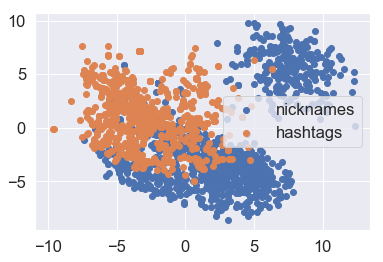

In [149]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:1000,0],X_pca[:1000,1],  label = "nicknames")
plt.scatter(X_pca[1000:,0],X_pca[1000:,1],  label = "hashtags")
plt.legend()

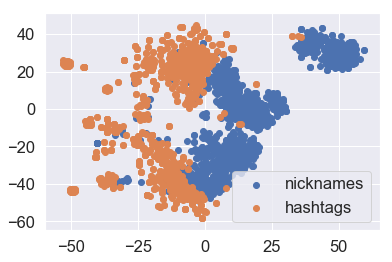

In [150]:
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:1000,0],X_tsne[:1000,1],  label = "nicknames")
plt.scatter(X_tsne[1000:,0],X_tsne[1000:,1],  label = "hashtags")
plt.legend()

In [182]:
emb_hks = emb_hks.reshape(1000, 1024)
emb_nks = emb_nks.reshape(1000, 1024)

s = np.zeros(1024)
size = 0

for vec in emb_nks:
    s += np.sum((emb_hks - vec)**2, axis=0)
    size += 1

mean_distance = s/size

In [192]:
mean_distance[:5]

array([321.97585196, 261.49048831, 488.76331393, 360.33752589,
       363.0802304 ])

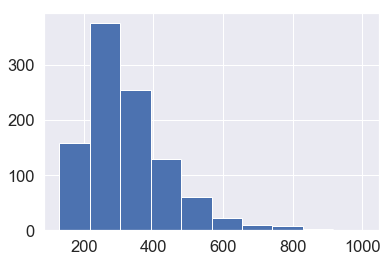

In [188]:
plt.hist(mean_distance)
plt.show()